In [1]:
%cd ~/repo/protein-transfer

/home/t-fli/repo/protein-transfer


In [2]:
%load_ext blackcellmagic

In [3]:
from scr.analysis.perlayer import LayerLoss

In [7]:
"""Analyzing per layer output"""

from __future__ import annotations

from collections import defaultdict

import os
from glob import glob
import numpy as np

import matplotlib.pyplot as plt

from scr.params.emb import TRANSFORMER_INFO
from scr.utils import pickle_load, get_filename, checkNgen_folder


class LayerLoss:
    """A class for handling layer analysis"""

    def __init__(
        self,
        input_path: str = "results/sklearn",
        output_path: str = "results/sklearn_layer",
        metric_list: list[str] = ["train_mse", "test_ndcg", "test_rho"],
    ):
        """
        Args:
        - input_path: str = "results/sklearn",
        - output_path: str = "results/sklearn_layer"
        - metric_list: list[str] = ["train_mse", "test_ndcg", "test_rho"]
        """
        # get rid of the last "/" if any
        self._input_path = os.path.normpath(input_path)
        # get the list of subfolders for each dataset
        self._dataset_folders = glob(f"{self._input_path}/*/*/*/*/*")
        # glob("results/train_val_test/*/*/*/*/*")

        # get rid of the last "/" if any
        self._output_path = os.path.normpath(output_path)
        self._metric_list = metric_list
        self._metric_numb = len(metric_list)

        # init a dictionary for recording outputs
        self._layer_analysis_dict = defaultdict(dict)

        for dataset_folder in self._dataset_folders:
            # dataset_folder = "results/train_val_test/proeng/gb1/two_vs_rest/esm1b_t33_650M_UR50S/max"
            # get the details for the dataset such as proeng/gb1/two_vs_rest
            task_subfolder = dataset_folder.split(self._input_path + "/")[-1]
            # task_subfolder = "proeng/gb1/two_vs_rest/esm1b_t33_650M_UR50S/max"
            task, dataset, split, encoder_name, flatten_emb = task_subfolder.split("/")

            self._layer_analysis_dict[f"{task}_{dataset}_{split}_{flatten_emb}"][
                encoder_name
            ] = self.parse_result_dicts(
                dataset_folder, task, dataset, split, encoder_name, flatten_emb
            )

        collage_folder = os.path.join(output_path, "collage")
        checkNgen_folder(collage_folder)

        for collage_name, encoder_dict in self._layer_analysis_dict.items():
            encoder_names = list(TRANSFORMER_INFO.keys())
            assert set(encoder_names) > set(
                encoder_dict.keys()
            ), "Unrecognized encoder names"
            fig, axs = plt.subplots(
                self._metric_numb,
                len(encoder_names),
                sharey="row",
                sharex="col",
                figsize=(20, 10),
            )
            for m, metric in enumerate(metric_list):
                for n, encoder_name in enumerate(encoder_names):
                    axs[m, n].plot(encoder_dict[encoder_name][metric])

            # add xlabels
            for ax in axs[self._metric_numb - 1]:
                ax.set_xlabel("layers", fontsize=16)
                ax.tick_params(axis="x", labelsize=16)

            # add column names
            for ax, col in zip(axs[0], encoder_names):
                ax.set_title(col, fontsize=16)

            # add row names
            for ax, row in zip(axs[:, 0], metric_list):
                ax.set_ylabel(row.replace("_", " "), fontsize=16)
                ax.tick_params(axis="y", labelsize=16)

            # add whole plot level title
            fig.suptitle(collage_name.replace("_", " "), fontsize=20, fontweight="bold")
            fig.tight_layout()

            for plot_ext in [".svg", ".png"]:
                plt.savefig(
                    os.path.join(collage_folder, collage_name + plot_ext),
                    bbox_inches="tight",
                )

            plt.close()

    def parse_result_dicts(
        self,
        folder_path: str,
        task: str,
        dataset: str,
        split: str,
        encoder_name: str,
        flatten_emb: bool | str,
    ):
        """
        Parse the output result dictionaries for plotting

        Args:
        - folder_path: str, the folder path for the datasets

        Returns:
        - dict, encode name as key with a dict as its value
            where metric name as keys and the array of losses as values
        - str, details for collage plot
        """

        # get the list of output pickle files
        pkl_list = glob(f"{folder_path}/*.pkl")

        # get the max layer number for the array
        max_layer_numb = TRANSFORMER_INFO[encoder_name][1] + 1

        # init the ouput dict
        output_numb_dict = {
            metric: np.zeros([max_layer_numb]) for metric in self._metric_list
        }

        # loop through the list of the pickle files
        for pkl_file in pkl_list:
            # get the layer number
            layer_numb = int(get_filename(pkl_file).split("-")[-1].split("_")[-1])
            # load the result dictionary
            result_dict = pickle_load(pkl_file)

            # populate the processed dictionary
            for metric in self._metric_list:
                subset, kind = metric.split("_")
                if kind == "rho":
                    output_numb_dict[metric][layer_numb] = result_dict[subset][kind][0]
                else:
                    output_numb_dict[metric][layer_numb] = result_dict[subset][kind]

            # get some details for plotting and saving
            output_subfolder = checkNgen_folder(
                folder_path.replace(self._input_path, self._output_path)
            )

        for metric in output_numb_dict.keys():

            plot_name = f"{encoder_name}_{flatten_emb}_{metric}"
            plot_prefix = f"{task}_{dataset}_{split}"

            plt.figure()
            plt.plot(output_numb_dict[metric])
            plt.title(f"{plot_prefix} \n {plot_name}")
            plt.xlabel("layers")
            plt.ylabel("loss")

            for plot_ext in [".svg", ".png"]:
                plt.savefig(
                    os.path.join(output_subfolder, plot_name + plot_ext),
                    bbox_inches="tight",
                )
            plt.close()

        return output_numb_dict

    @property
    def layer_analysis_dict(self) -> dict:
        """Return a dict with dataset name as the key"""
        return self._layer_analysis_dict

In [4]:
layer_analysis_dict = LayerLoss(
    input_path="results/train_val_test",
    output_path="results/analysis_layer",
).layer_analysis_dict

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

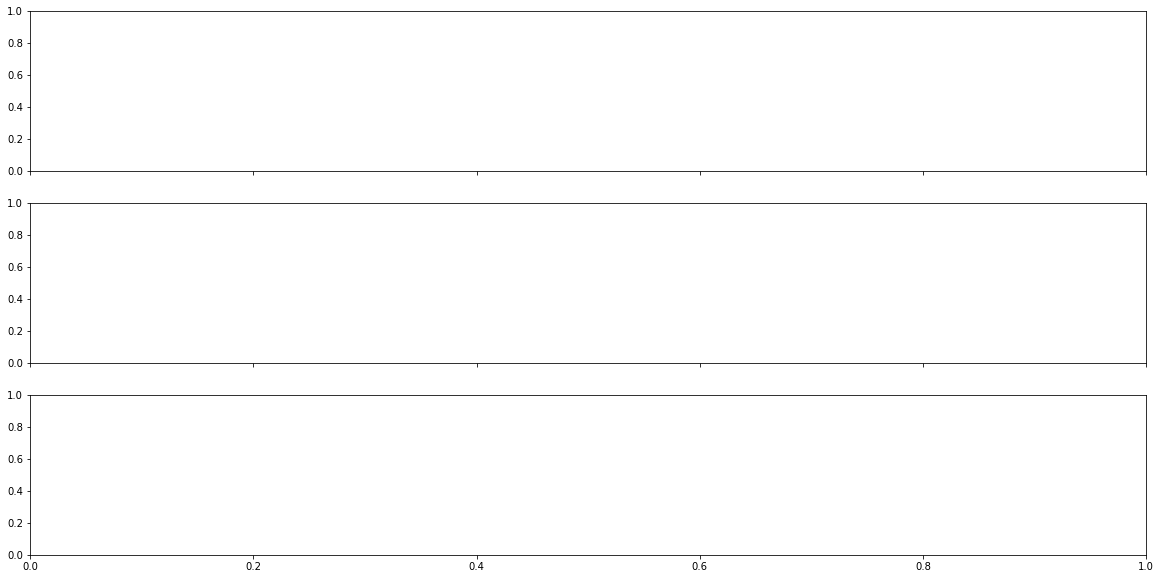

In [4]:
layer_analysis_dict = LayerLoss(
    input_path="results/sklearn",
    output_path="results/sklearn_layer",
).layer_analysis_dict

In [32]:
layer_analysis_dict.keys(), layer_analysis_dict["proeng_gb1_low_vs_high_mean"].keys(), layer_analysis_dict["proeng_gb1_low_vs_high_mean"]["esm1b_t33_650M_UR50S"].keys()

(dict_keys(['proeng_gb1_two_vs_rest_mean', 'proeng_gb1_low_vs_high_mean', 'proeng_aav_one_vs_many_mean']),
 dict_keys(['esm1b_t33_650M_UR50S', 'esm1_t6_43M_UR50S', 'esm1_t12_85M_UR50S', 'esm1_t34_670M_UR50S']),
 dict_keys(['train_mse', 'test_ndcg', 'test_rho']))